In [93]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0" #! specify gpu here

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
import json
import warnings
from pathlib import Path
import random
import base64
from io import BytesIO
import cv2
import vision_pipeline.obb
import imagesize
# from scipy import ndimage
import natsort
from PIL import Image as PILImage
from PIL import ImageDraw, ImageFilter
import numpy as np
from tqdm import tqdm
from shapely.geometry import Polygon
from rich import print
from types import SimpleNamespace
import pickle
import imutils

# ros package
from context_action_framework.types import Detection, Label, Module, Camera
from sensor_msgs.msg import Image, CameraInfo # CameraInfo needed for pickle

# local imports
from vision_pipeline.helpers import Struct, make_valid_poly, img_to_camera_coords
from context_action_framework.graph_relations import GraphRelations, exists_detection, compute_iou
from vision_pipeline.work_surface_detection_opencv import WorkSurfaceDetection
from vision_pipeline.object_detection_model import ObjectDetectionModel
from vision_pipeline.object_detection import ObjectDetection
from vision_pipeline.object_reid import ObjectReId

from vision_pipeline.config import load_config

from vision_pipeline.object_reid_superglue import ObjectReIdSuperGlue


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
config = load_config("../config.yaml")

config.reid = False

# pretend to use Basler camera
camera_type = Camera.basler
camera_name = camera_type.name

camera_config = config.basler

camera_config.enable_topic = "set_sleeping" # basler camera specific
camera_config.enable_camera_invert = True # enable = True, but the topic is called set_sleeping, so the inverse
camera_config.use_worksurface_detection = True

model = ObjectDetectionModel(config.obj_detection)

object_detection = ObjectDetection(config, 
                                        camera_config,
                                        model=model,
                                        object_reid=None,
                                        camera=Camera.basler,
                                        frame_id="",
                                        use_ros=False)

config:
{
    'node_name': 'vision',
    'reid': False,
    'basler': {
        'target_fps': 2,
        'max_allowed_acquisition_delay': 1.0,
        'rotate_img': 180,
        'topic': 'basler',
        'camera_node': '/basler',
        'image_topic': 'image_rect_color',
        'publish_labelled_img': True,
        'publish_graph_img': False,
        'has_depth': False,
        'run_continuous': True,
        'wait_for_services': False,
        'detect_arucos': False,
        'parent_frame': 'vision_table_zero',
        'create_parent_frame': False,
        'marker_lifetime': 1,
        'work_surface_ignore_border_width': 100,
        'show_work_surface_detection': True,
        'debug_work_surface_detection': False
    },
    'realsense': {
        'target_fps': 10,
        'max_allowed_acquisition_delay': 1.0,
        'rotate_img': 0,
        'topic': 'realsense',
        'camera_node': '/realsense',
        'image_topic': 'color/image_raw',
        'info_topic': 'color/camera_info',
        'depth_topic': 'aligned_depth_to_color/image_raw',
        'publish_labelled_img': True,
        'publish_depth_img': True,
        'publish_cluster_img': True,
        'publish_graph_img': False,
        'has_depth': True,
        'run_continuous': True,
        'wait_for_services': False,
        'detect_arucos': False,
        'camera_height': 0.2,
        'parent_frame': 'panda_2/realsense',
        'create_parent_frame': False,
        'marker_lifetime': 1,
        'calibration_file': '/root/vision-pipeline/realsense_calib/realsense_calib.yaml',
        'debug_clustering': False
    },
    'obj_detection': {
        'debug': True,
        'model': 'yolov8',
        'yolact_dataset_file': '~/vision_pipeline/data_limited/yolact/2023-07-18_firealarms_hcas/dataset.json',
        'yolact_score_threshold': 0.5,
        'yolov8_model_file': 
'~/vision_pipeline/data_limited/yolov8/output_2023-09-25_40000_early_stopping3/best.pt',
        'yolov8_score_threshold': 0.5,
        'superglue_templates': '~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted_cropped',
        'superglue_model_file': '~/superglue_training/output/train/2023-11-18_superglue_model/weights/best.pt',
        'superglue_match_threshold': 0.5,
        'classifier_model_file': 
'~/device_reid/results/2024-01-02__12-56_classify_WORKING/lightning_logs/version_0/checkpoints/epoch=598-step=598.c
kpt'
    }
}

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model.learning_rate 1e-05

model.batch_size 16

model.freeze_backbone False

curr_weights_path /home/docker/superglue_training/output/train/2023-11-18_superglue_model/weights/best.pt

Loaded SuperPoint model
Loaded SuperGlue model ("/home/docker/superglue_training/output/train/2023-11-18_superglue_model/weights/best.pt" weights)


100%|██████████| 61/61 [00:00<00:00, 139.23it/s]


Loaded superglue templates 61

In [95]:
# img_path = os.path.expanduser("~/datasets2/reconcycle/2023-02-20_hca_backs_UNLABELED/hca_0/0001.jpg")
# img_path = os.path.expanduser("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/firealarm_back_09/0333.jpg")
# img_path = os.path.expanduser("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/firealarm_back_15/0792.jpg")
# img_path = os.path.expanduser("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted/firealarm_back_12/0588.jpg")
# img_path = os.path.expanduser("~/datasets2/reconcycle/2024-01-02_14:27:09_basler/0004.jpg")

img_path = os.path.expanduser("~/vision_pipeline/saves/2024-01-04_14:22:15_basler/0012.jpg")


img = cv2.imread(img_path)
img = imutils.resize(img, width=1450, height=1450)

# display(PILImage.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

running worksurface detection...

corners_m_dict
{'corner_t': [0.6, 0.6], 'corner_r': [0.6, 0], 'corner_b': [0, 0], 'corner_l': [0, 0.6]}

infer_classify
torch.Size([1, 3, 300, 300])

classify_label firealarm_front_05 conf tensor(0.9823, device='cuda:0')

img1.shape
(600, 600, 3)

img1.shape
(300, 300, 3)

starting compare...

angle_est using findHomography 0.3105271802472131 degrees: 17.791896852263495

elapsed_time_classify_and_rot 0.05373178608715534

infer_classify
torch.Size([1, 3, 300, 300])

classify_label hca_front_05 conf tensor(0.5495, device='cuda:0')

img1.shape
(600, 600, 3)

img1.shape
(300, 300, 3)

starting compare...

not enough matches for SuperGlue 0

elapsed_time_classify_and_rot 0.04941777139902115

firealarm_front, edge large: 0.134m, edge small: 0.133m

firealarm_back, edge large: 0.08m, edge small: 0.018m

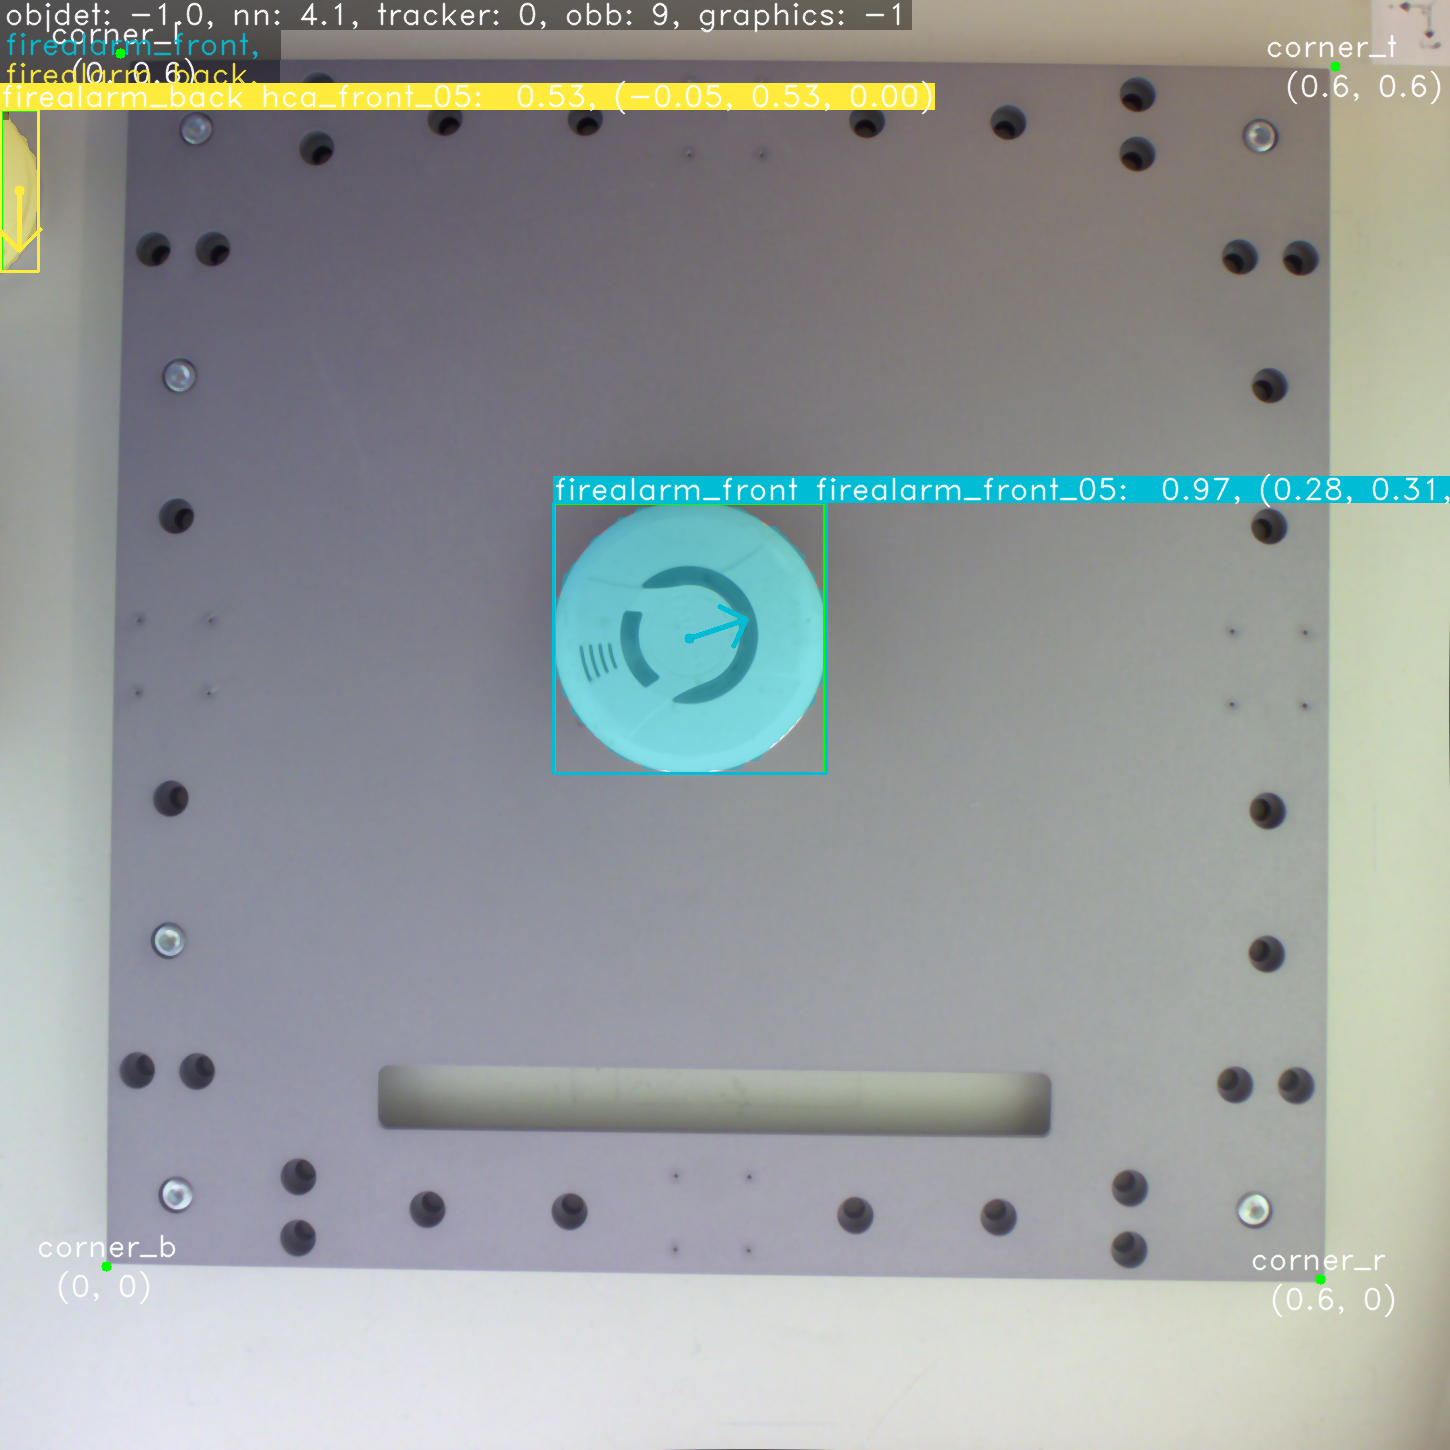

In [96]:
worksurface_detection = WorkSurfaceDetection(img, camera_config.work_surface_ignore_border_width, debug=camera_config.debug_work_surface_detection)

labelled_img, detections, markers, poses, graph_img, graph_relations = object_detection.get_prediction(img, depth_img=None, worksurface_detection=worksurface_detection, extra_text=None, camera_info=None, use_tracker=False, use_classify=True) 

#! specify use_classify=True if you want it to classify and estimate rotation

display(PILImage.fromarray(cv2.cvtColor(labelled_img, cv2.COLOR_BGR2RGB)))

sample_crop
(400, 400, 3)
for label Label.firealarm_front

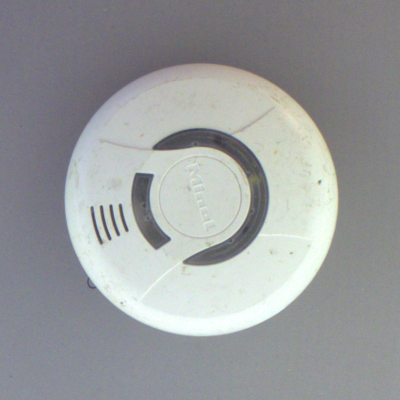

infer_classify
torch.Size([1, 3, 300, 300])

classify_label firealarm_front_05 tensor(0.9953, device='cuda:0')

img1.shape
(600, 600, 3)

img1.shape
(300, 300, 3)

starting compare...

angle_est using findHomography 0.3001924898996739 degrees: 17.19976271277491

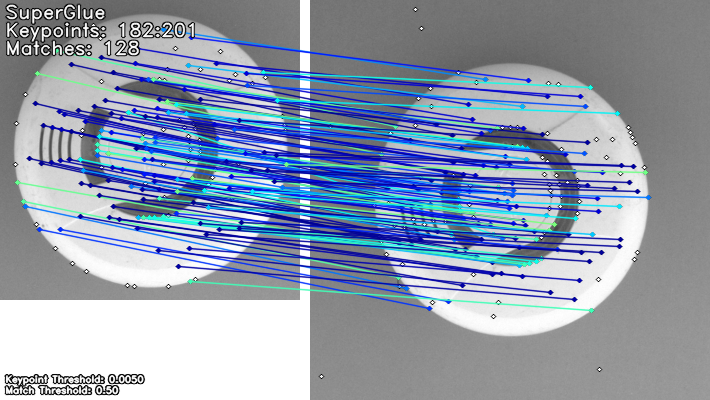

sample_crop
(390, 219, 3)
for label Label.firealarm_back

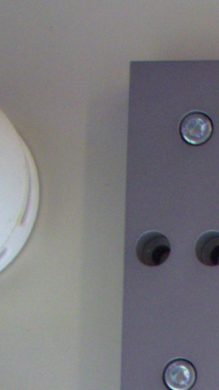

infer_classify
torch.Size([1, 3, 300, 300])

classify_label hca_front_05 tensor(0.3354, device='cuda:0')

img1.shape
(600, 600, 3)

img1.shape
(300, 300, 3)

starting compare...

not enough matches for SuperGlue 1

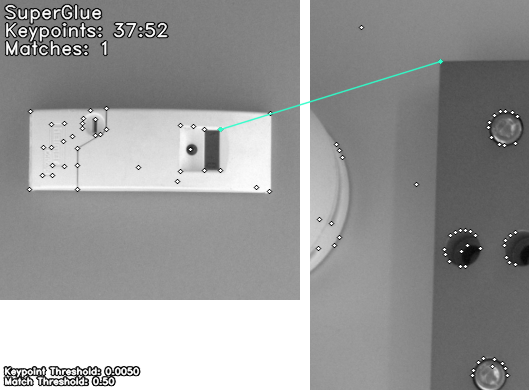

In [98]:
for detection in detections:
    if detection.label in [Label.firealarm_front, Label.firealarm_back]:
        
        # todo: crop to detection given detection
        sample_crop, _ = ObjectReId.crop_det(img, detection, size=400)

        print("sample_crop", sample_crop.shape, "for label", detection.label)

        display(PILImage.fromarray(cv2.cvtColor(sample_crop, cv2.COLOR_BGR2RGB)))

        classify_label, conf = model.infer_classify(sample_crop)

        print("classify_label", classify_label, conf)

        if conf > 0.5:

            angle, vis_out = model.superglue_rot_estimation(sample_crop, classify_label)

            display(PILImage.fromarray(vis_out))

            # update angle
            detection.angle_px = angle